# Visual Question Answering (VQA) System with LoRA Fine-Tuned BLIP

This notebook implements a VQA system using the BLIP model (`Salesforce/blip-vqa-base`) fine-tuned with Low-Rank Adaptation (LoRA) on a specific dataset. It processes images and questions, generates answers, and evaluates performance using metrics like Exact Match, Token Match, WUP Score, F1 Score, and BERTScore. The system includes data splitting, custom dataset handling, error analysis, and visualizations.

## Objectives
- Load and preprocess image metadata and VQA dataset from `/kaggle/input/vr-project-json/vqa_training_data_complete.json`.
- Split data into training (80%) and testing (20%) sets.
- Fine-tune the BLIP model using LoRA with a custom dataset and dataloader.
- Run inference with the fine-tuned model on the test set.
- Evaluate predictions with comprehensive metrics, including yes/no question analysis.
- Perform error analysis and visualize results.

## Prerequisites
- Python libraries: `torch`, `transformers`, `peft`, `pandas`, `numpy`, `Pillow`, `nltk`, `sklearn`, `tqdm`, `matplotlib`, `seaborn`.
- NLTK data: `wordnet`, `punkt`, `averaged_perceptron_tagger`, `averaged_perceptron_tagger_eng`.
- Dataset: Images and a JSON file with VQA questions and answers.
- Hardware: GPU recommended for fine-tuning and inference (CUDA support).

In [ ]:
import os
import json
import csv
import torch
import numpy as np
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering, BertTokenizer, BertModel, get_scheduler
from peft import LoraConfig, get_peft_model
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import wordnet as wn
from collections import Counter
import re
import types
from torch.utils.data import Dataset, DataLoader

# Make sure necessary NLTK packages are downloaded
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Define paths
IMAGE_BASE_DIR = r"/kaggle/input/vr-project-images/images/small"
VQA_DATA_FILE = "/kaggle/input/vr-project-json/vqa_training_data_complete.json"
# VQA_DATA_FILE = "/kaggle/input/vr-project-temp-json/temp.json"
INPUT_IMAGES_FILE = "/kaggle/input/vr-project-images/images/metadata/images.csv"
OUTPUT_RESULTS_FILE = "/kaggle/working/vqa_results.csv"
OUTPUT_METRICS_FILE = "/kaggle/working/vqa_metrics.json"
MODEL_SAVE_PATH = "/kaggle/working/blip_lora_finetuned"

## Custom Dataset and Collate Function

We define:
- **`VQADataset`**: A PyTorch `Dataset` class that loads VQA data, processes images and questions, and tokenizes answers as labels.
- **`collate_fn`**: A custom collate function to pad inputs (`pixel_values`, `input_ids`, `attention_mask`) and labels for batched training.

These ensure efficient data loading and batching during fine-tuning.

In [ ]:
class VQADataset(Dataset):
    def __init__(self, vqa_data, image_map, processor, image_base_dir):
        self.vqa_data = vqa_data
        self.image_map = image_map
        self.processor = processor
        self.image_base_dir = image_base_dir

    def __len__(self):
        total = 0
        for item in self.vqa_data:
            total += len(item["questions"])
        return total

    def __getitem__(self, idx):
        current_idx = 0
        for item in self.vqa_data:
            for q_item in item["questions"]:
                if current_idx == idx:
                    image_id = item["image_id"]
                    question = q_item["question"]
                    answer = q_item["answer"]
                    
                    # Clean answer
                    answer = re.sub(r'[^\w\s]', '', answer).strip()
                    
                    image_path = os.path.join(self.image_base_dir, self.image_map[image_id]["path"])
                    if not os.path.exists(image_path):
                        raise FileNotFoundError(f"Image not found at {image_path}")
                    image = Image.open(image_path).convert('RGB')
                    
                    # Process inputs
                    inputs = self.processor(images=image, text=question, return_tensors="pt", padding=True)
                    
                    # Tokenize answer
                    answer_tokens = self.processor.tokenizer(
                        answer,
                        return_tensors="pt",
                        padding="max_length",
                        truncation=True,
                        max_length=20
                    )
                    inputs["labels"] = answer_tokens["input_ids"]
                    
                    # Validate labels
                    vocab_size = self.processor.tokenizer.vocab_size
                    if inputs["labels"].max().item() >= vocab_size:
                        print(f"Warning: Invalid token ID in labels for answer: {answer}")
                        inputs["labels"] = torch.clamp(inputs["labels"], max=vocab_size - 1)
                    
                    return inputs
                current_idx += 1
        raise IndexError("Index out of range")

# Custom collate function to pad tensors
def collate_fn(batch, processor):
    """Custom collate function to pad inputs and labels to the same length."""
    pixel_values = torch.stack([item["pixel_values"].squeeze(0) for item in batch])
    input_ids = [item["input_ids"].squeeze(0) for item in batch]
    attention_mask = [item["attention_mask"].squeeze(0) for item in batch]
    labels = [item["labels"].squeeze(0) for item in batch]
    
    # Pad input_ids, attention_mask, and labels
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for ignored indices in loss
    
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

## Data Loading

The following functions load data:
- `load_image_metadata`: Reads image metadata from a CSV into a dictionary mapping image IDs to properties (height, width, path).
- `load_vqa_data`: Loads the VQA dataset from the JSON file `vqa_training_data_complete.json`.

These support both training and inference.

In [3]:
def load_image_metadata():
    """Load image metadata from CSV into a dictionary."""
    image_map = {}
    with open(INPUT_IMAGES_FILE, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            image_map[row["image_id"]] = {
                "height": int(row["height"]),
                "width": int(row["width"]),
                "path": row["path"]
            }
    return image_map

def load_vqa_data():
    """Load the VQA dataset from JSON."""
    with open(VQA_DATA_FILE, "r", encoding="utf-8") as f:
        vqa_data = json.load(f)
    return vqa_data

## Model Setup and LoRA Configuration

The system uses:
- **BLIP (`Salesforce/blip-vqa-base`)**: Fine-tuned with LoRA for VQA tasks.
- **BERT (`bert-base-uncased`)**: For BERTScore calculation.

Key functions:
- `configure_lora`: Applies LoRA to BLIP, targeting `query` and `value` modules, with a custom forward method to handle unsupported arguments.
- `fine_tune_with_lora`: Fine-tunes BLIP using the custom dataset, AdamW optimizer, and a linear learning rate scheduler.
- `setup_bertscore_model`: Initializes BERT for evaluation.

In [ ]:
def configure_lora(model):
    """Configure LoRA for the BLIP model with a custom forward wrapper for base_model."""
    lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.05,
        bias="none",
        task_type="QUESTION_ANS"
    )
    model = get_peft_model(model, lora_config)
    
    # Store the original base_model forward method
    original_base_forward = model.base_model.forward
    
    # Define a custom forward method to filter out unsupported arguments
    def custom_base_forward(self, *args, **kwargs):
        # Filter out unsupported arguments for BLIP forward
        supported_kwargs = {
            k: v for k, v in kwargs.items()
            if k in [
                "pixel_values", "input_ids", "attention_mask", "labels",
                "output_attentions", "output_hidden_states", "return_dict",
                "interpolate_pos_encoding"
            ]
        }
        return original_base_forward(*args, **supported_kwargs)
    
    # Bind the custom forward method to the base_model
    model.base_model.forward = types.MethodType(custom_base_forward, model.base_model)
    
    model.print_trainable_parameters()
    return model

def fine_tune_with_lora(image_map,train_data):
    """Fine-tune the BLIP model with LoRA."""

    # image_map = load_image_metadata()
    # vqa_data = load_vqa_data()
    
    # Initialize model and processor
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
    
    # Apply LoRA with custom forward
    model = configure_lora(model)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize dataset and dataloader
    train_dataset = VQADataset(train_data, image_map, processor,IMAGE_BASE_DIR)
    dataloader = DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=True,
        num_workers=2,
        collate_fn=lambda batch: collate_fn(batch, processor),
        pin_memory=True
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    num_epochs = 3
    num_training_steps = len(dataloader) * num_epochs
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    model.train()
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}")
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}"):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")
    
    model.save_pretrained(MODEL_SAVE_PATH)
    processor.save_pretrained(MODEL_SAVE_PATH)
    
    return processor, model, device


def setup_bertscore_model():
    """Initialize models for BERTScore calculation."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

## Answer Normalization and Evaluation Metrics

We normalize answers and compute:
- **Normalization** (`normalize_answer`): Converts numbers to words, removes articles and punctuation, and standardizes whitespace.
- **Exact Match** (`exact_match`): Checks if normalized answers are identical.
- **Token Match** (`token_match`): Compares token sets for exact overlap.
- **Wu-Palmer Similarity** (`calculate_wup_score`): Measures semantic similarity using WordNet.
- **F1 Score** (`calculate_f1_score`): Computes token-based precision, recall, and F1 score.
- **BERTScore** (`calculate_bertscore`): Evaluates semantic similarity using BERT embeddings.

In [7]:
def normalize_answer(s):
    """Normalize answer for more accurate comparison."""
    # Define reversed number map (digits to words)
    number_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', '10': 'ten'
    }
    
    # Convert digits to words
    for digit, word in number_map.items():
        s = re.sub(r'\b' + digit + r'\b', word, s.lower())
    
    # Remove articles
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    # Remove punctuation and extra whitespace
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def calculate_bertscore(pred, ref, tokenizer, model, device):
    """Calculate BERTScore between prediction and reference."""
    pred_tokens = tokenizer(pred, return_tensors='pt', padding=True, truncation=True).to(device)
    ref_tokens = tokenizer(ref, return_tensors='pt', padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        pred_outputs = model(**pred_tokens)
        ref_outputs = model(**ref_tokens)
    
    pred_embedding = pred_outputs.last_hidden_state[:, 0, :]
    ref_embedding = ref_outputs.last_hidden_state[:, 0, :]
    
    pred_embedding = pred_embedding / pred_embedding.norm(dim=1, keepdim=True)
    ref_embedding = ref_embedding / ref_embedding.norm(dim=1, keepdim=True)
    
    similarity = torch.matmul(pred_embedding, ref_embedding.transpose(0, 1)).item()
    
    return similarity

def exact_match(pred, ref):
    """Check if prediction exactly matches reference after normalization."""
    return normalize_answer(pred) == normalize_answer(ref)

def token_match(pred, ref):
    """Check if the tokens in prediction match the reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    return Counter(pred_tokens) == Counter(ref_tokens)

def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNet."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
    return tag_dict.get(tag, wn.NOUN)

def calculate_wup_score(pred, ref):
    """Calculate Wu-Palmer similarity score between prediction and reference."""
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()
    
    if not pred_tokens or not ref_tokens:
        return 0.0
    
    max_similarities = []
    
    for p_token in pred_tokens:
        token_max_sim = 0.0
        p_synsets = wn.synsets(p_token, pos=get_wordnet_pos(p_token))
        
        if not p_synsets:
            p_synsets = wn.synsets(p_token)
            
        if not p_synsets:
            continue
            
        for r_token in ref_tokens:
            r_synsets = wn.synsets(r_token, pos=get_wordnet_pos(r_token))
            
            if not r_synsets:
                r_synsets = wn.synsets(r_token)
                
            if not r_synsets:
                continue
                
            token_sims = []
            for p_syn in p_synsets:
                for r_syn in r_synsets:
                    try:
                        sim = wn.wup_similarity(p_syn, r_syn)
                        if sim is not None:
                            token_sims.append(sim)
                    except:
                        continue
            
            if token_sims:
                token_max_sim = max(token_max_sim, max(token_sims))
        
        if token_max_sim > 0:
            max_similarities.append(token_max_sim)
    
    return sum(max_similarities) / len(max_similarities) if max_similarities else 0.0

def calculate_f1_score(pred, ref):
    """Calculate F1 score between prediction and reference tokens."""
    pred_tokens = set(normalize_answer(pred).split())
    ref_tokens = set(normalize_answer(ref).split())
    
    if not pred_tokens and not ref_tokens:
        return 1.0
    
    if not pred_tokens or not ref_tokens:
        return 0.0
    
    common_tokens = pred_tokens.intersection(ref_tokens)
    
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(ref_tokens)
    
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * precision * recall / (precision + recall)
    return f1

## Running Inference

The `run_inference` function processes the test dataset:
- Uses the fine-tuned BLIP model to generate answers.
- Loads images and questions from the test set.
- Computes evaluation metrics (Exact Match, Token Match, WUP, F1, BERTScore).
- Saves results to a CSV file.

It includes error handling for missing images or processing issues.

In [8]:
def run_inference(processor, model, device,test_data):
    """Run VQA inference on the dataset and save results with detailed metrics."""
    # image_map = load_image_metadata()
    # vqa_data = load_vqa_data()
    
    bert_tokenizer, bert_model, bert_device = setup_bertscore_model()
    
    results = []
    
    for item in tqdm(test_data, desc="Processing VQA items"):
        image_id = item["image_id"]
        
        if image_id not in image_map:
            print(f"Warning: Image ID {image_id} not found in metadata. Skipping.")
            continue
        
        image_path = os.path.join(IMAGE_BASE_DIR, image_map[image_id]["path"])
        
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found at {image_path}. Skipping.")
            continue
        
        try:
            image = Image.open(image_path).convert('RGB')
            
            for q_item in item["questions"]:
                question = q_item["question"]
                ground_truth = q_item["answer"]
                
                inputs = processor(images=image, text=question, return_tensors="pt").to(device)
                
                with torch.no_grad():
                    generated_ids = model.generate(**inputs)
                    predicted_answer = processor.decode(generated_ids[0], skip_special_tokens=True)
                
                em_score = exact_match(predicted_answer, ground_truth)
                token_match_score = token_match(predicted_answer, ground_truth)
                wup_score = calculate_wup_score(predicted_answer, ground_truth)
                f1 = calculate_f1_score(predicted_answer, ground_truth)
                bertscore = calculate_bertscore(predicted_answer, ground_truth, bert_tokenizer, bert_model, bert_device)
                
                results.append({
                    "image_id": image_id,
                    "question": question,
                    "ground_truth": normalize_answer(ground_truth),
                    "predicted_answer": normalize_answer(predicted_answer),
                    "exact_match": em_score,
                    "token_match": token_match_score,
                    "wup_score": wup_score,
                    "f1_score": f1,
                    "bertscore": bertscore
                })
                
        except Exception as e:
            print(f"Error processing image {image_id}: {str(e)}")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_RESULTS_FILE, index=False)
    
    return results_df


## Evaluating Results

The `evaluate_results` function analyzes inference results:
- Computes overall metrics (mean Exact Match, Token Match, WUP, F1, BERTScore).
- Categorizes questions (counting, color, yes/no, other).
- Analyzes yes/no questions with binary classification metrics.
- Saves metrics to a JSON file and prints a summary.

In [9]:
def evaluate_results(results_df):
    """Evaluate and print detailed metrics from the results."""
    metrics = {
        "overall": {
            "exact_match": results_df["exact_match"].mean(),
            "token_match": results_df["token_match"].mean(),
            "wup_score": results_df["wup_score"].mean(),
            "f1_score": results_df["f1_score"].mean(),
            "bertscore": results_df["bertscore"].mean()
        }
    }
    
    results_df["question_type"] = "other"
    results_df.loc[results_df["question"].str.contains("how many|number|count", case=False), "question_type"] = "counting"
    results_df.loc[results_df["question"].str.contains("color|colour", case=False), "question_type"] = "color"
    results_df.loc[results_df["question"].str.startswith(("Is ", "Are ", "Does ", "Do ", "Can ", "Could ", "Has ", "Have ")), "question_type"] = "yes/no"
    
    question_types = results_df["question_type"].unique()
    metrics["by_question_type"] = {}
    
    for qtype in question_types:
        subset = results_df[results_df["question_type"] == qtype]
        metrics["by_question_type"][qtype] = {
            "count": len(subset),
            "exact_match": subset["exact_match"].mean(),
            "token_match": subset["token_match"].mean(),
            "wup_score": subset["wup_score"].mean(),
            "f1_score": subset["f1_score"].mean(),
            "bertscore": subset["bertscore"].mean()
        }
    
    yes_no_df = results_df[results_df["question_type"] == "yes/no"]
    if len(yes_no_df) > 0:
        yes_no_df["gt_binary"] = yes_no_df["ground_truth"].str.lower().apply(
            lambda x: 1 if x in ["yes", "yeah", "true"] else 0)
        yes_no_df["pred_binary"] = yes_no_df["predicted_answer"].str.lower().apply(
            lambda x: 1 if x in ["yes", "yeah", "true"] else 0)
        
        metrics["yes_no_analysis"] = {
            "accuracy": (yes_no_df["gt_binary"] == yes_no_df["pred_binary"]).mean(),
            "precision": precision_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "recall": recall_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "f1": f1_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0)
        }
    
    with open(OUTPUT_METRICS_FILE, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print("\n===== VQA Evaluation Results =====")
    print(f"Total questions evaluated: {len(results_df)}")
    print(f"Exact match accuracy: {metrics['overall']['exact_match']:.4f}")
    print(f"Token match accuracy: {metrics['overall']['token_match']:.4f}")
    print(f"Average WUP score: {metrics['overall']['wup_score']:.4f}")
    print(f"Average F1 score: {metrics['overall']['f1_score']:.4f}")
    print(f"Average BERTScore: {metrics['overall']['bertscore']:.4f}")
    
    print("\n===== Results by Question Type =====")
    for qtype, qmetrics in metrics["by_question_type"].items():
        print(f"\n{qtype.upper()} Questions ({qmetrics['count']} questions):")
        print(f"  Exact match: {qmetrics['exact_match']:.4f}")
        print(f"  Token match: {qmetrics['token_match']:.4f}")
        print(f"  WUP score: {qmetrics['wup_score']:.4f}")
        print(f"  F1 score: {qmetrics['f1_score']:.4f}")
        print(f"  BERTScore: {qmetrics['bertscore']:.4f}")
    
    if "yes_no_analysis" in metrics:
        print("\n===== Yes/No Question Analysis =====")
        print(f"  Accuracy: {metrics['yes_no_analysis']['accuracy']:.4f}")
        print(f"  Precision: {metrics['yes_no_analysis']['precision']:.4f}")
        print(f"  Recall: {metrics['yes_no_analysis']['recall']:.4f}")
        print(f"  F1 score: {metrics['yes_no_analysis']['f1']:.4f}")
    
    return metrics

## Error Analysis

The `run_error_analysis` function identifies failure cases:
- Finds the 10 worst-performing questions based on averaged metrics.
- Analyzes error rates by question type.
- Examines correlation between ground truth answer length and accuracy.
- Studies F1 score distribution.

In [10]:
def run_error_analysis(results_df):
    """Perform detailed error analysis on the results."""
    results_df["avg_score"] = (
        results_df["exact_match"] + 
        results_df["token_match"] + 
        results_df["wup_score"] + 
        results_df["f1_score"] + 
        results_df["bertscore"]
    ) / 5
    
    worst_cases = results_df.sort_values("avg_score").head(10)
    
    print("\n===== Worst Performing Cases =====")
    for i, (_, row) in enumerate(worst_cases.iterrows()):
        print(f"\nCase {i+1}:")
        print(f"Image ID: {row['image_id']}")
        print(f"Question: {row['question']}")
        print(f"Ground Truth: {row['ground_truth']}")
        print(f"Prediction: {row['predicted_answer']}")
        print(f"Metrics: EM={row['exact_match']}, TM={row['token_match']}, WUP={row['wup_score']:.4f}, "
              f"F1={row['f1_score']:.4f}, BERTScore={row['bertscore']:.4f}")
    
    error_df = results_df[~results_df["exact_match"]]
    
    results_df["gt_length"] = results_df["ground_truth"].apply(len)
    results_df["pred_length"] = results_df["predicted_answer"].apply(len)
    results_df["length_diff"] = abs(results_df["pred_length"] - results_df["gt_length"])
    
    error_by_qtype = error_df.groupby("question_type").size()
    total_by_qtype = results_df.groupby("question_type").size()
    error_rate_by_qtype = (error_by_qtype / total_by_qtype).fillna(0)
    
    print("\n===== Error Analysis by Question Type =====")
    for qtype, error_rate in error_rate_by_qtype.items():
        print(f"{qtype}: {error_rate:.4f} error rate ({error_by_qtype[qtype]} errors out of {total_by_qtype[qtype]} questions)")
    
    corr = results_df["gt_length"].corr(results_df["exact_match"])
    print(f"\nCorrelation between answer length and accuracy: {corr:.4f}")
    
    f1_ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    f1_distribution = {}
    
    for low, high in f1_ranges:
        count = ((results_df["f1_score"] >= low) & (results_df["f1_score"] < high)).sum()
        f1_distribution[f"{low}-{high}"] = count
    
    perfect_f1 = (results_df["f1_score"] == 1.0).sum()
    f1_distribution["1.0"] = perfect_f1
    
    print("\n===== F1 Score Distribution =====")
    for range_name, count in f1_distribution.items():
        percentage = count / len(results_df) * 100
        print(f"F1 Score {range_name}: {count} questions ({percentage:.2f}%)")
    
    return {
        "worst_cases": worst_cases,
        "error_by_qtype": error_by_qtype,
        "error_rate_by_qtype": error_rate_by_qtype,
        "length_correlation": corr,
        "f1_distribution": f1_distribution
    }


## Visualizing Metrics

The `visualize_metrics` function creates:
- Histograms of F1, WUP, and BERTScore distributions.
- Count plot of Exact Match results.
- Boxplots of metrics by question type.
- Saves plots as `metric_distributions.png` and `metrics_by_question_type.png`.

**Note**: Requires `matplotlib` and `seaborn`.

In [12]:
def visualize_metrics(results_df):
    """Create visualizations of the evaluation metrics."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        sns.set_style("whitegrid")
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        sns.histplot(data=results_df, x="f1_score", bins=20, kde=True)
        plt.title("Distribution of F1 Scores")
        plt.xlabel("F1 Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 2)
        sns.histplot(data=results_df, x="wup_score", bins=20, kde=True)
        plt.title("Distribution of WUP Scores")
        plt.xlabel("WUP Score")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 3)
        sns.histplot(data=results_df, x="bertscore", bins=20, kde=True)
        plt.title("Distribution of BERTScores")
        plt.xlabel("BERTScore")
        plt.ylabel("Frequency")
        
        plt.subplot(2, 2, 4)
        sns.countplot(data=results_df, x="exact_match")
        plt.title("Exact Match Counts")
        plt.xlabel("Exact Match (0=No, 1=Yes)")
        plt.ylabel("Count")
        
        plt.tight_layout()
        plt.savefig("metric_distributions.png")
        
        plt.figure(figsize=(15, 10))
        metrics = ["f1_score", "wup_score", "bertscore"]
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.boxplot(data=results_df, x="question_type", y=metric)
            plt.title(f"{metric} by Question Type")
            plt.xlabel("Question Type")
            plt.ylabel(metric)
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig("metrics_by_question_type.png")
        
        print("\nVisualization images saved as 'metric_distributions.png' and 'metrics_by_question_type.png'")
        
    except ImportError:
        print("\nNote: matplotlib and seaborn are required for visualization. Install with: pip install matplotlib seaborn")


## Main Execution

The main block runs the pipeline:
1. Loads and splits data into training and testing sets.
2. Fine-tunes BLIP with LoRA.
3. Runs inference on the test set.
4. Evaluates results and performs error analysis.
5. Generates visualizations.
6. Saves outputs and the fine-tuned model.

2025-05-12 05:08:34.590132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747026514.789210      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747026514.844432      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_da

Starting VQA fine-tuning and evaluation process...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fine-tuning BLIP with LoRA...


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

trainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6096
Starting epoch 1/3


Epoch 1: 100%|██████████| 9732/9732 [34:06<00:00,  4.76it/s]


Epoch 1 average loss: 7.8861
Starting epoch 2/3


Epoch 2: 100%|██████████| 9732/9732 [34:02<00:00,  4.76it/s]


Epoch 2 average loss: 7.8029
Starting epoch 3/3


Epoch 3: 100%|██████████| 9732/9732 [34:02<00:00,  4.77it/s]


Epoch 3 average loss: 7.7932
Running inference with fine-tuned model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing VQA items: 100%|██████████| 1774/1774 [10:25<00:00,  2.84it/s]
/tmp/ipykernel_19/2803315919.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yes_no_df["gt_binary"] = yes_no_df["ground_truth"].str.lower().apply(
/tmp/ipykernel_19/2803315919.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yes_no_df["pred_binary"] = yes_no_df["predicted_answer"].str.lower().apply(


Evaluating results...

===== VQA Evaluation Results =====
Total questions evaluated: 4848
Exact match accuracy: 0.6735
Token match accuracy: 0.6735
Average WUP score: 0.8058
Average F1 score: 0.6759
Average BERTScore: 0.9745

===== Results by Question Type =====

COLOR Questions (1577 questions):
  Exact match: 0.7330
  Token match: 0.7330
  WUP score: 0.8653
  F1 score: 0.7334
  BERTScore: 0.9843

YES/NO Questions (1195 questions):
  Exact match: 0.8544
  Token match: 0.8544
  WUP score: 0.8930
  F1 score: 0.8544
  BERTScore: 0.9898

OTHER Questions (1441 questions):
  Exact match: 0.5121
  Token match: 0.5121
  WUP score: 0.6209
  F1 score: 0.5199
  BERTScore: 0.9512

COUNTING Questions (635 questions):
  Exact match: 0.5512
  Token match: 0.5512
  WUP score: 0.9136
  F1 score: 0.5512
  BERTScore: 0.9740

===== Yes/No Question Analysis =====
  Accuracy: 0.9439
  Precision: 0.9222
  Recall: 0.9721
  F1 score: 0.9465
Performing error analysis...

===== Worst Performing Cases =====

Cas

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Visualization images saved as 'metric_distributions.png' and 'metrics_by_question_type.png'

Results saved to /kaggle/working/vqa_results.csv
Detailed metrics saved to /kaggle/working/vqa_metrics.json
Fine-tuned model saved to /kaggle/working/blip_lora_finetuned


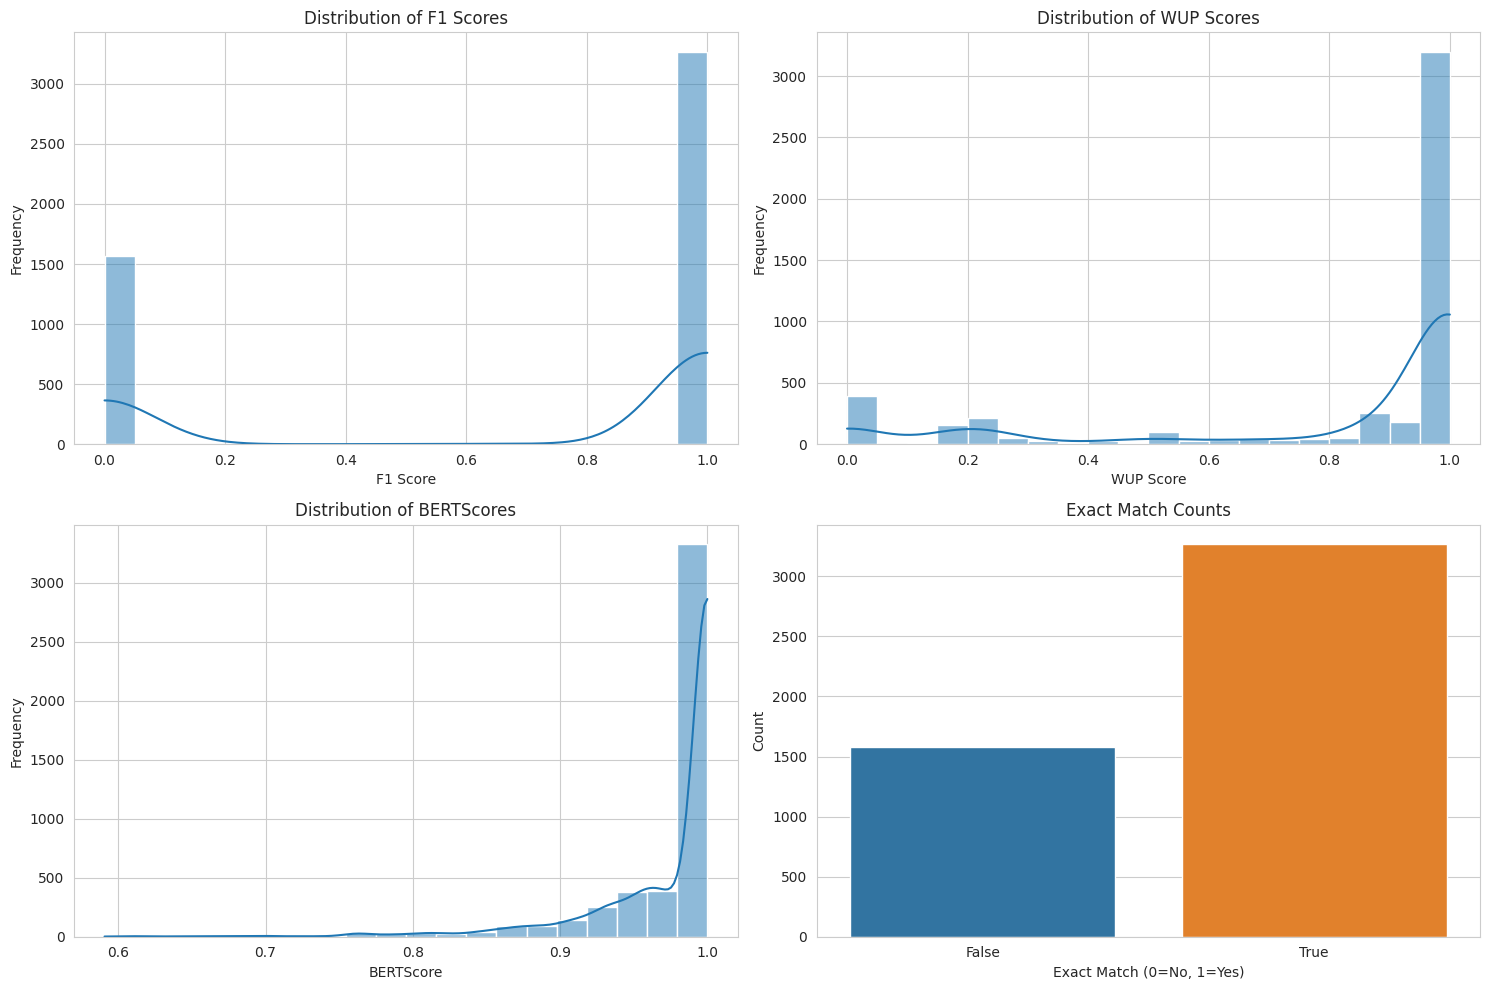

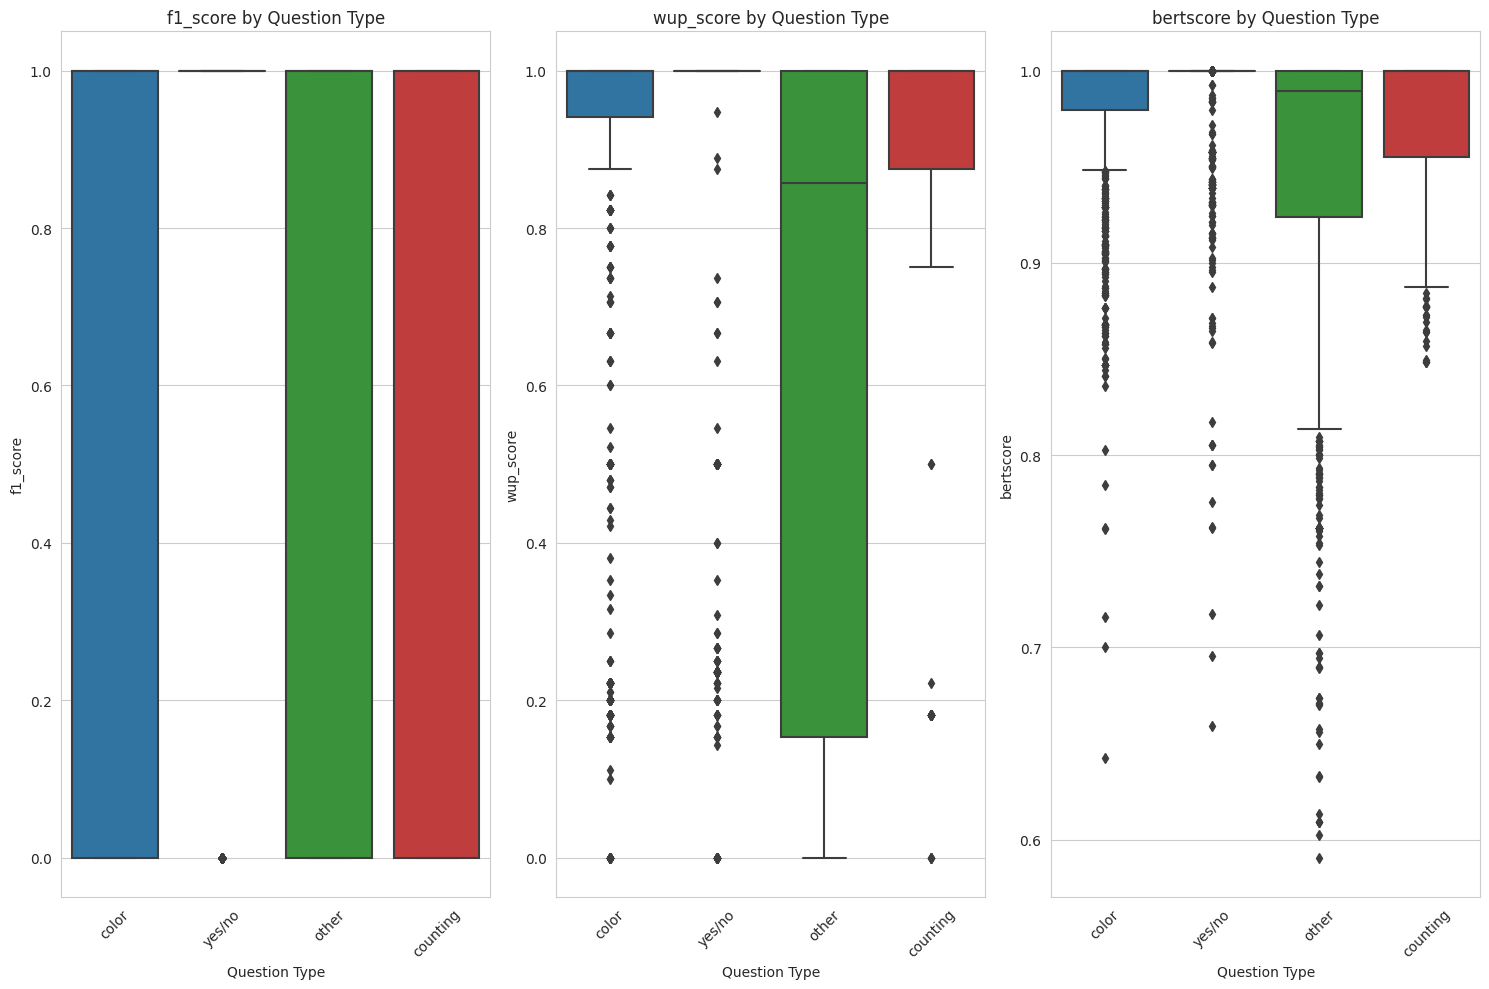

In [ ]:
if __name__ == "__main__":
    print("Starting VQA fine-tuning and evaluation process...")
    
    # Load data
    image_map = load_image_metadata()
    vqa_data = load_vqa_data()
    
    # Split dataset into train and validation
    train_data, test_data = train_test_split(vqa_data, test_size=0.2, random_state=42)
    
    
    print("Fine-tuning BLIP with LoRA...")
    processor, model, device = fine_tune_with_lora(image_map,train_data)
    
    print("Running inference with fine-tuned model...")
    results = run_inference(processor, model, device,test_data)
    
    print("Evaluating results...")
    metrics = evaluate_results(results)
    
    print("Performing error analysis...")
    error_analysis = run_error_analysis(results)
    
    print("Generating visualizations...")
    visualize_metrics(results)
    
    print(f"\nResults saved to {OUTPUT_RESULTS_FILE}")
    print(f"Detailed metrics saved to {OUTPUT_METRICS_FILE}")
    print(f"Fine-tuned model saved to {MODEL_SAVE_PATH}")